In [62]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageOps, ImageFilter
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoModel, AutoProcessor
import warnings
import torch
import time
import requests
from io import BytesIO
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
HOME: str = os.getenv('HOME') # echo $HOME
USER: str = os.getenv('USER') # echo $USER
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_models = [
	"openai/clip-vit-base-patch32", # original
	"openai/clip-vit-large-patch14",
	"laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
]

if USER=="farid": # local laptop
	WDIR = os.path.join(HOME, "datasets")
	models_dir = os.path.join(WDIR, "trash", "models")
	model_fpth = pretrained_models[0]
elif USER=="alijanif": # Puhti
	WDIR = "/scratch/project_2004072/ImACCESS"
	models_dir = os.path.join(WDIR, "trash", "models")
	model_fpth = pretrained_models[1]
else: # Pouta
	WDIR = "/media/volume/ImACCESS"
	models_dir = os.path.join(HOME, WDIR, "models")
	model_fpth = pretrained_models[1]

# Load the CLIP model and processor
model = CLIPModel.from_pretrained(model_fpth, cache_dir=models_dir)
processor = CLIPProcessor.from_pretrained(model_fpth, cache_dir=models_dir)

In [3]:
# Load and preprocess images
# "https://www.archives.gov/files/research/military/ww2/photos/images/ww2-14.jpg"
base_url = "https://www.archives.gov/files/research/military/ww2/photos/images/ww2-"
image_urls = [f"{base_url}{i:02d}.jpg" for i in range(1, 203)]
print(f"Fetching {len(image_urls)} image url(s)...")
t0 = time.time()
images = []
for url in image_urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  images.append(img)
print(f"Loaded {len(images)} images in {time.time()-t0:.2f} sec")

Fetching 202 image url(s)	Loaded 202 images in 66.79 sec


# Image2Text Retrieval

# Text2Image Retrieval

In [4]:
# Encode images and text
text = "Cemetery"
inputs = processor(text=[text], images=images, return_tensors="pt", padding=True)

# Compute similarity scores
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
print(logits_per_image.shape, type(logits_per_image))
probs = logits_per_image.softmax(dim=1)  # Convert logits to probabilities
print(probs.shape, type(probs))


torch.Size([202, 1]) <class 'torch.Tensor'>
torch.Size([202, 1]) <class 'torch.Tensor'>


In [5]:
# Ensure top_k is not greater than the number of images
top_k = min(3, len(images))
top_k_indices = probs.topk(top_k, dim=0).indices.squeeze().tolist()
print(top_k_indices, type(top_k_indices))
# Handle the case where top_k_indices is not a list (e.g., when there's only one image)
if isinstance(top_k_indices, int):
  top_k_indices = [top_k_indices]

top_k_images = [images[i] for i in top_k_indices]
print(top_k_images) # [<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1100x1396 at 0x78A40EF4B910>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1104x1387 at 0x78A40EF4BBB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1437x1066 at 0x78A40EA22730>]

[0, 1, 2] <class 'list'>
[<PIL.JpegImagePlugin.JpegImageFile image mode=L size=1100x1396 at 0x7701BEF5E970>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1104x1387 at 0x770340181400>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1437x1066 at 0x7703401810D0>]


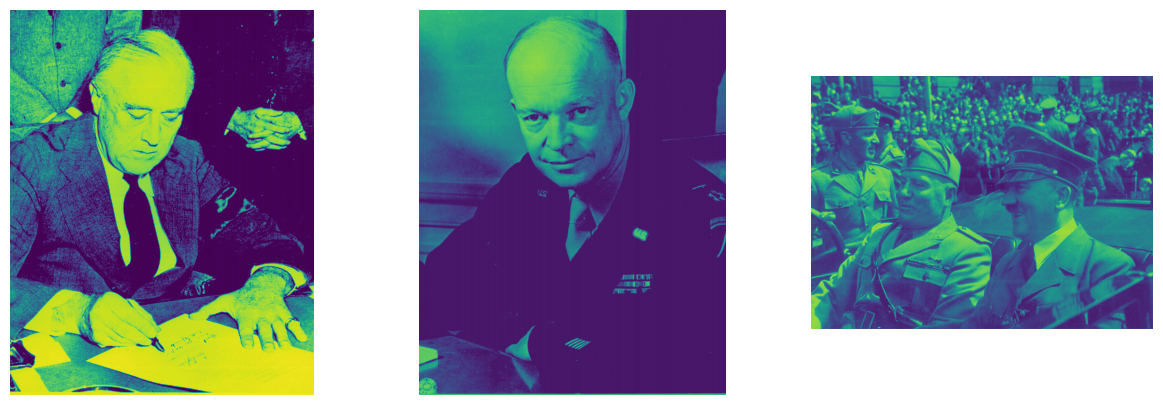

In [6]:
fig, axes = plt.subplots(1, top_k, figsize=(15, 5))
for i, img in enumerate(top_k_images):
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

In [89]:
def preprocess_historical(image):
		"""
		Preprocess the image with special handling for historical photos.
		
		Args:
			image: PIL Image object
		
		Returns:
			Preprocessed PIL Image
		"""
		# Convert to grayscale and back to RGB for consistency
		image = ImageOps.grayscale(image)
		image = Image.merge('RGB', (image, image, image))
		
		# Enhance contrast to deal with historical photo quality
		image = ImageOps.autocontrast(image, cutoff=2)
		
		# Remove noise using Gaussian blur
		image = image.filter(ImageFilter.GaussianBlur(radius=0.1))
		
		return image

In [92]:
def resize_and_pad(image_pth, img_sz):
	image = Image.open(image_pth)#.convert('RGB')
	print(image.mode)
	image = preprocess_historical(image)
	original_width, original_height = image.size
	aspect_ratio = original_width / original_height
	if aspect_ratio > 1:
		new_width = img_sz
		new_height = int(img_sz / aspect_ratio)
	else:
		new_height = img_sz
		new_width = int(img_sz * aspect_ratio)
	image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
	# Compute padding to center the image
	pad_width = (img_sz - new_width) // 2
	pad_height = (img_sz - new_height) // 2
	# Apply padding to ensure the image is square
	padding = (
		pad_width, 
		pad_height, 
		img_sz - new_width - pad_width, 
		img_sz - new_height - pad_height
	)
	image = ImageOps.expand(image, padding, fill=(0, 0, 0))
	# print(image.size) # must be square => e.g., (250 x 250)
	return image

L
(224, 224) <class 'PIL.Image.Image'> RGB


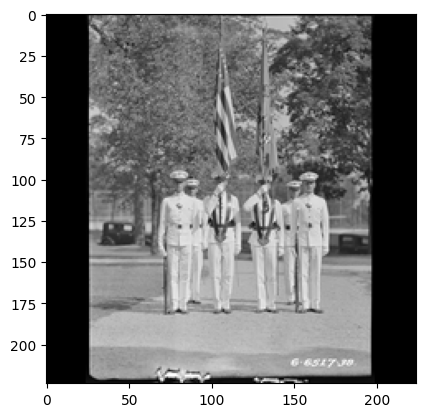

In [93]:
img_pth = "/home/farid/WS_Farid/ImACCESS/txt2img/datasets/national_archive/NATIONAL_ARCHIVE_1933-01-01_1933-01-02/images/239942421.jpg"
# img_pth = "/home/farid/WS_Farid/ImACCESS/txt2img/fashionCLIP/myntradataset/images/1570.jpg"
modifed_img = resize_and_pad(image_pth=img_pth, img_sz=224)
print(modifed_img.size, type(modifed_img), modifed_img.mode)
plt.imshow(modifed_img)
plt.show()

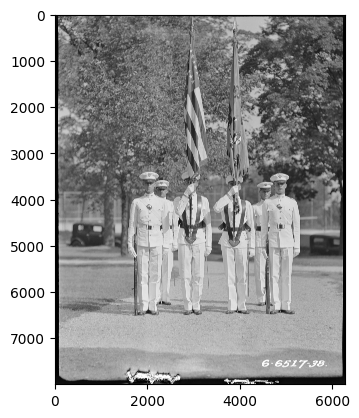

In [69]:
plt.imshow(Image.open(img_pth).convert('RGB'))
plt.show()

In [51]:
def resize_with_aspect_ratio(img_pth: str, target_size: int) -> Image.Image:
        """
        Resize image maintaining aspect ratio and handling extreme aspect ratios.
        
        Args:
            image: PIL Image object
            target_size: Desired size for the shorter dimension
            
        Returns:
            Resized PIL Image
        """
        image = Image.open(img_pth)#.convert('RGB')
        w, h = image.size
        aspect_ratio = w / h
        
        # Handle extreme aspect ratios
        if aspect_ratio > 3 or aspect_ratio < 1/3:
            # Center crop the image to bring aspect ratio within bounds
            if aspect_ratio > 3:
                new_w = int(h * 3)
                left = (w - new_w) // 2
                image = image.crop((left, 0, left + new_w, h))
            else:
                new_h = int(w * 3)
                top = (h - new_h) // 2
                image = image.crop((0, top, w, top + new_h))
        
        # Compute new dimensions
        if w > h:
            new_h = target_size
            new_w = int(new_h * aspect_ratio)
        else:
            new_w = target_size
            new_h = int(new_w / aspect_ratio)
            
        image = image.resize((new_w, new_h), Image.Resampling.LANCZOS)
        return image

In [52]:
def pad_square(
        image: Image.Image,
        target_size: int
    ) -> Image.Image:
        """
        Pad image to square with black borders.
        
        Args:
            image: PIL Image object
            target_size: Desired size for both dimensions
            
        Returns:
            Padded square PIL Image
        """
        w, h = image.size
        delta_w = target_size - w
        delta_h = target_size - h
        padding = (
            delta_w // 2,
            delta_h // 2,
            delta_w - (delta_w // 2),
            delta_h - (delta_h // 2)
        )
        return ImageOps.expand(image, padding, fill=0)

(319, 224) <class 'PIL.Image.Image'>
(224, 224) <class 'PIL.Image.Image'>


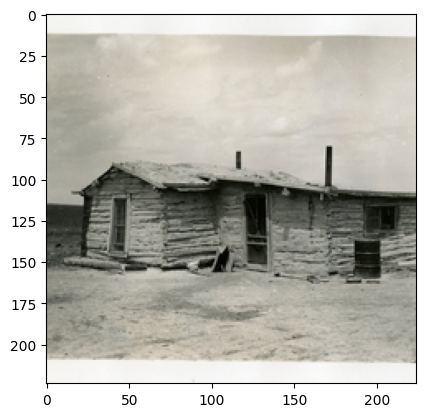

In [53]:
modifed_img = resize_with_aspect_ratio(img_pth=img_pth, target_size=224)
print(modifed_img.size, type(modifed_img))

modifed_img = pad_square(modifed_img, target_size=224)
print(modifed_img.size, type(modifed_img))

plt.imshow(modifed_img)
plt.show()